In [1]:
import numpy as np
import pandas as pd
import csv
import json
import os
import ast
from gensim.models.keyedvectors import KeyedVectors
# from sklearn.cluster import KMeans
# # import scipy.cluster.hierarchy as sch
# from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec
from scipy.special import comb
import os

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords
import re


D:\anaconda\envs\py37\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
datapath = r'D:\projects\congress\data\debate_politics\filtered_data\\'

In [3]:
member = pd.read_csv(datapath + 'member_filtered.csv', index_col = 0)

In [4]:
member

,<fullpath>,name,massages,score,points,awards,birthday,location,gender,occupation,political_leaning,signature
0,https://debatepolitics.com/members/r-ighteous-...,(R)IGHTeous 1,152,12,0,NaN,"Feb 2, 1986\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\...",southeast PA,Male,FB page.....,Conservative,"THIS is what a young, urban, mixed Latino, GAY..."
1,https://debatepolitics.com/members/oozlefinch....,Oozlefinch,"14,128","10,629",0,17,"Dec 27, 1964\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...",State of Jefferson,Male,Computer Technician,Moderate,"War is an ugly thing, but not the ugliest of t..."
4,https://debatepolitics.com/members/peteeu.2747...,PeteEU,"35,962","12,440",0,19,NaN,Denmark,Male,Self employed,Centrist,PeteEU
7,https://debatepolitics.com/members/wangyong.38...,WangYong,0,0,0,NaN,February 1,NaN,Male,NaN,Liberal,NaN
8,https://debatepolitics.com/members/catzrock.37...,!CatzRock,3,1,0,NaN,May 24,NaN,NaN,NaN,Conservative,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14279,https://debatepolitics.com/members/waterwolf.2...,Waterwolf,9,3,0,NaN,NaN,New Jersey,Male,Semi-Retired Home Health R.N.,Moderate,NaN
14281,https://debatepolitics.com/members/wbreese91.8...,wbreese91,407,111,0,NaN,NaN,"Marietta, Ohio",Male,"College Student, Marietta College",Centrist,“Justitia suum cuique distribuit” Justice rend...
14283,https://debatepolitics.com/members/wdavis.2073...,wdavis,15,3,0,NaN,NaN,NaN,Male,NaN,Moderate,NaN
14286,https://debatepolitics.com/members/weirdojoker...,WeirdoJoker,48,20,0,NaN,NaN,The Twilight Zone,Male,Solo-practice attorney,Liberal,Aarf! --Shadowfax


In [5]:
member['political_leaning'].unique()

array(['Conservative', 'Moderate', 'Centrist', 'Liberal',
       'Slightly Conservative', 'Slightly Liberal', 'Very Liberal',
       'Very Conservative'], dtype=object)

In [6]:
# get 7 scale measurement, 7 most lib, 1 most conservative
def func(string):
    a = 4
    if string =="Conservative":
        a = 2
    if string == 'Very Conservative':
        a = 1
    if string == 'Very Liberal':
        a = 7
    if string == 'Liberal':
        a = 6
    if string == 'Slightly Liberal':
        a = 5
    if string == 'Slightly Conservative':
        a = 3
    return a
member['slant_lib'] = member.loc[:, 'political_leaning'].apply(func)

In [154]:
member['slant_lib']

0        2
1        4
4        4
7        6
8        2
        ..
14279    4
14281    4
14283    4
14286    6
14291    1
Name: slant_lib, Length: 4816, dtype: int64

In [ ]:
# get percentagage of lib:con


In [155]:
speeches_raw = pd.read_csv(datapath + 'debatepolitics_filtered.csv', index_col = None)

In [156]:
speeches_raw.head()

,<fullpath>,一级论坛,二级论坛,三级论坛,标题,主贴发布时间,正文,作者,作者链接,发布时间,点赞用户
0,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,I expect to thread to go this well,tacomancer,https://debatepolitics.com/members/tacomancer....,2021-06-22T12:27:05-0400,"OrphanSlug, RaleBulgarian, OlNate and 3 others"
1,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T12:32:53-0400,"code1211, LadyMoonlight, vesper and 4 others"
2,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,ecofarm said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T12:48:29-0400,trixare4kids
3,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,tacomancer said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n...,Dragonfly,https://debatepolitics.com/members/dragonfly.4...,2021-06-22T12:54:54-0400,OlNate
4,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T13:02:59-0400,Josie


In [161]:
speeches_raw.loc[:, '二级论坛'].unique()

array(['Abortion', 'General Political Discussion',
       'International Politics', 'US State and Local', 'US Constitution',
       'US Partisan Politics and Political Platforms', 'Military',
       'Law and Order', 'Tech Support', 'Archives',
       'Battle Grounds and Disputations', 'Bias in the Media',
       'Sex and Sexuality', 'Feedback / Suggestions',
       'Announcements / Forum News', 'The Loft',
       'COVID-19 - Coronavirus Disease', 'DP Games',
       'Government Spending and Debt', 'Government Regulation',
       'Breaking News', 'Come in and say Hi', 'Leisure Activities'],
      dtype=object)

In [162]:
# speeches_sel = speeches_raw.loc[speeches_raw.loc[:, '二级论坛'].isin(['Abortion'])]

In [163]:
# a = speeches_sel['正文'].iloc[0]

In [164]:
cliches = r'Click to expand...'

In [165]:
# remove quotes, which is before cliches

# a.split(cliches)

In [166]:
speeches_raw['speech']= speeches_raw.loc[:, '正文'].apply(lambda x: x.split(cliches)[-1] if x is not np.nan else "")

In [167]:
speeches_raw['speech'].head()

0                   I expect to thread to go this well
1    \n\t\nIt isn't a "ZEF". It's a human.\n\nWhen ...
2    \n\t\nHey! There's another forum you can use t...
3                      \n\t\nBest post of the month!!!
4    \n\t\n\nOf course it is. Life begins at fertil...
Name: speech, dtype: object

In [168]:
import re

In [169]:
regex = re.compile('[^a-zA-Z ]')
speeches_raw['speech'] = speeches_raw['speech'].apply(lambda x: re.sub('\s+', ' ', regex.sub('',x)).lower())\
    .apply(lambda x: re.sub(r'\b(were|youre|im|hes|shes|theyre|ive)\b','',x))\
    .apply(lambda x: re.sub(r'\b(didnt|dont|doesnt|cant|wont|havent|hasnt|isnt)\b', 'not',x))

In [170]:
speeches_raw['speech'].head()

0                   i expect to thread to go this well
1    it not a zef its a humanwhen a human egg is fe...
2    hey theres another forum you can use to troll ...
3                               best post of the month
4    of course it is life begins at fertilization t...
Name: speech, dtype: object

In [171]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords
from gensim.models.keyedvectors import KeyedVectors
# from sklearn.cluster import KMeans
# # import scipy.cluster.hierarchy as sch
# from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec

In [172]:
CUSTOM_FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords]

In [173]:
speeches_raw['speech_proc'] = speeches_raw.loc[:, 'speech'].apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

In [174]:
speeches_raw['speech_proc'].apply(lambda x: len(x)).describe()

count    1.431723e+06
mean     2.205551e+01
std      2.818411e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.400000e+01
75%      2.700000e+01
max      6.720000e+02
Name: speech_proc, dtype: float64

In [175]:
speeches_raw['speech_proc'].sample(1000)

174064     [thisrun, candidates, like, mcgrath, orouke, j...
901876     [chose, tap, issue, brief, reply, instead, add...
1276605    [police, officer, thinks, appreciably, safer, ...
1228786    [ship, democracy, weathered, storms, sink, mut...
955980     [demand, artificially, supported, deficit, spe...
                                 ...                        
162540     [million, lifetime, capfirst, thats, particula...
375149                                    [teach, act, like]
871950     [care, vote, abortion, alabama, long, choice, ...
845567     [gun, fantasies, concern, mejust, need, hand, ...
993037     [yes, agree, mean, imply, entering, country, i...
Name: speech_proc, Length: 1000, dtype: object

In [176]:
speeches_raw['speech_proc2'] = speeches_raw['speech_proc'].apply(lambda x: [i for i in x if (not i.startswith('http')) and (not i.startswith('www'))]).apply(lambda x: [i for i in x if len(i)<=25 and len(i)>=2])

In [177]:
speeches_raw['speech_proc2'].head()

0                                     [expect, thread]
1    [zef, humanwhen, human, egg, fertilized, resul...
2       [hey, theres, forum, use, troll, like, thread]
3                                  [best, post, month]
4    [course, life, begins, fertilization, proven, ...
Name: speech_proc2, dtype: object

In [178]:
speeches_long = speeches_raw.loc[speeches_raw['speech_proc2'].apply(lambda x: len(x))>=10]

In [179]:
del speeches_raw

In [ ]:
# step 1 update word embedding

In [180]:
sentences= speeches_long.speech_proc2.values.tolist()

In [181]:
len(sentences)

895811

In [182]:
sentences = np.array(sentences)

In [183]:
model = Word2Vec.load(r'D:\projects\congress\embedding/' + r'w2v_update_to_trump.model')

In [184]:
model.build_vocab(sentences, update= True)

In [185]:
model.train(sentences, total_examples=model.corpus_count, epochs = 5)

(138578223, 144763120)

In [186]:
model.save(r'D:\projects\congress\embedding/' + 'w2v_from_trump_to_debatepol.model')

In [192]:
model.wv.save(r'D:\projects\congress\embedding/' + 'kv_trump_to_debatepol.kv')

In [ ]:
# step 2: update topic vectors

In [194]:
id_topics_dic = {0: 'ip', 1: 'it', 2: 'abortion', 3: 'academic', 4: 'agriculture', 5: 'business', 6: 'children', 7: 'china', 8: 'commerce', 9: 'crime', 
10: 'culture', 11: 'homelandsecurity', 12: 'detainee', 13: 'disadvantaged', 14: 'disaster', 15: 'discrimination', 16: 'disease', 
17: 'addictives', 18: 'economy', 19: 'education', 20: 'environment', 21: 'family', 22: 'federal', 23: 'finance', 24: 'fiscal', 
25: 'food', 26: 'guns', 27: 'health', 28: 'healthcare', 29: 'hightech', 30: 'housing', 31: 'immigration', 32: 'industry', 33: 'cyber',
34: 'infrastructure', 35: 'international', 36: 'iransyrialibya', 37: 'iraq', 38: 'israel', 39: 'jury', 40: 'lgbtq', 41: 'media',
42: 'militarycomplex', 43: 'natives', 44: 'nuclear', 45: 'police', 46: 'politicalact', 47: 'postal', 48: 'randd', 49: 'religion',
50: 'renewable', 51: 'reserves', 52: 'russia', 53: 'safety', 54: 'sport', 55: 'tax', 56: 'terrorism', 57: 'trade',
58: 'traditionalenergy', 59: 'transportation', 60: 'veteran', 61: 'vietnam', 62: 'vote', 63: 'waste', 64: 'welfare', 
65: 'woman', 66: 'workforce', 67:'other'}
topics_id_dic = {v:k for k, v in id_topics_dic.items()}

In [193]:

kvs = KeyedVectors.load(r'D:\projects\congress\embedding/' + 'kv_trump_to_debatepol.kv', mmap='r')



In [197]:
fpath = r'D:\projects\congress\processed\topics\\'+'topic_seeds_fordebate.csv'

with open(fpath, 'r') as f:
    lines = f.readlines()
topics_seeds={}
for line in lines:
    l=line.strip('\n').split(',')
    l=[el.lower() for el in l if el not in ['','\n']]
    topics_seeds[l[0]]=list(set(l[1:]))
# t='finance'
# for el in w2v.wv.most_similar(positive=topics[t],topn=100):
#     print('{}   {}'.format(el[0],el[1]))





In [198]:
for t in['healthcare', 'guns', 'lgbtq', 'abortion']:
    print(topics_seeds[t])

['copayment', 'medicaid', 'patient', 'single', 'care', 'healthcare', 'universial', 'medicare', 'affordable', 'tricare', 'insurance', 'payer']
['hunting', 'weapons', 'concealed', 'massacre', 'arms', 'homicide', 'firearm', 'semi', 'assault', 'firearms', 'ownership', 'amendment', 'handgun', 'weapon', 'gun', 'armed', 'automatic', 'murder', 'criminal', 'munitions', 'ban', 'semiautomatic', 'nra', 'rifles', 'guns']
['bisexuality', 'religion', 'homophobia', 'lesbian', 'marriage', 'transgender', 'christianity', 'gay', 'christian', 'homosexualtiy', 'queer', 'lgbt', 'lgbtq', 'sexuality', 'sin', 'gays', 'orientation', 'christians', 'bisexual', 'bible', 'samesex', 'marry', 'couples', 'sexual', 'homosexual']
['womb', 'life', 'zygote', 'choice', 'parenthood', 'prolife', 'rape', 'fetus', 'contraception', 'abortions', 'babies', 'aborting', 'birth', 'fetuses', 'partial', 'abortion', 'thirdtrimester', 'prochoice', 'lateterm', 'fetal', 'pregnancy', 'partialbirth', 'baby']


In [199]:
topics_expanded={}
for topic in topics_id_dic.keys():
    if topic is not 'other':
        words=topics_seeds[topic]
        #words=[w.replace(' ','_') for w in words]
        words_invocab = [w for w in words if w in kvs.index2word]
        words_all = list(words_invocab)
    #     trash = [words_all.extend(w.split('_')) for w in words if kvs.vocab.get(w) is None] # trick to add split words not in vocab into a list and extend the list of all words
        expanded = kvs.most_similar(positive=words_all,topn=80)
        words_seed = [(i, 'seedwords')for i in words_all]
        topics_expanded[topic]= words_seed + expanded



In [200]:
# 
topics_cr = []
tpv_cr = []
for k,v in topics_expanded.items():
	topics_cr.append(k)
	vs = []
	for w, _ in v:
		vs.append(kvs.get_vector(w))
	tpv_cr.append(np.mean(vs, axis = 0))

tpv_cr = np.array(tpv_cr)
print(topics_cr)
tpv_cr.shape


# In[30]:


np.save(r'D:\projects\congress\processed\training_vectors\debatepol\\'+ r'debatepol_Topicvectors_noother', tpv_cr)

['ip', 'it', 'abortion', 'academic', 'agriculture', 'business', 'children', 'china', 'commerce', 'crime', 'culture', 'homelandsecurity', 'detainee', 'disadvantaged', 'disaster', 'discrimination', 'disease', 'addictives', 'economy', 'education', 'environment', 'family', 'federal', 'finance', 'fiscal', 'food', 'guns', 'health', 'healthcare', 'hightech', 'housing', 'immigration', 'industry', 'cyber', 'infrastructure', 'international', 'iransyrialibya', 'iraq', 'israel', 'jury', 'lgbtq', 'media', 'militarycomplex', 'natives', 'nuclear', 'police', 'politicalact', 'postal', 'randd', 'religion', 'renewable', 'reserves', 'russia', 'safety', 'sport', 'tax', 'terrorism', 'trade', 'traditionalenergy', 'transportation', 'veteran', 'vietnam', 'vote', 'waste', 'welfare', 'woman', 'workforce']


In [131]:
# parse matrix, keep only four toipics gun, health care, gay rights and abortion

In [201]:
speeches_long.head()

,<fullpath>,一级论坛,二级论坛,三级论坛,标题,主贴发布时间,正文,作者,作者链接,发布时间,点赞用户,speech,speech_proc,speech_proc2
1,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T12:32:53-0400,"code1211, LadyMoonlight, vesper and 4 others",it not a zef its a humanwhen a human egg is fe...,"[zef, humanwhen, human, egg, fertilized, resul...","[zef, humanwhen, human, egg, fertilized, resul..."
4,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T13:02:59-0400,Josie,of course it is life begins at fertilization t...,"[course, life, begins, fertilization, proven, ...","[course, life, begins, fertilization, proven, ..."
6,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T13:57:20-0400,"PirateMk1, eohrnberger and Josie",i have no expectation that everyone will see t...,"[expectation, things, way, hold, animosity, th...","[expectation, things, way, hold, animosity, th..."
7,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T15:50:53-0400,NaN,thanks even though i opposes all laws that vio...,"[thanks, opposes, laws, violate, th, amendment...","[thanks, opposes, laws, violate, th, amendment..."
9,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,MamboDervish said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T16:07:28-0400,NaN,the sperm is one cell in the dadthe ovum is on...,"[sperm, cell, dadthe, ovum, cell, momneither, ...","[sperm, cell, dadthe, ovum, cell, momneither, ..."


In [202]:
speeches_long['二级论坛'].unique()

array(['Abortion', 'General Political Discussion',
       'International Politics', 'US State and Local', 'US Constitution',
       'US Partisan Politics and Political Platforms', 'Military',
       'Law and Order', 'Tech Support', 'Archives',
       'Battle Grounds and Disputations', 'Bias in the Media',
       'Sex and Sexuality', 'Feedback / Suggestions',
       'Announcements / Forum News', 'The Loft',
       'COVID-19 - Coronavirus Disease', 'DP Games',
       'Government Spending and Debt', 'Government Regulation',
       'Breaking News', 'Come in and say Hi', 'Leisure Activities'],
      dtype=object)

In [203]:
speeches_long['三级论坛'].unique()

array([nan, 'Gun Control', 'Asia', 'Canada', 'West', 'Northeast',
       'Government & Separation of Powers', 'Russia / Ukraine / Belarus',
       'Australia and Oceania', 'Africa', 'US Elections', 'War on Terror',
       'War on drugs', 'Church and State', 'Middle East', 'Latin America',
       'Freedom of Speech', 'Environment & Climate Issues', 'Europe',
       'Midwest', 'Health Care', 'Immigration',
       'US Political Scandal Du Jour', 'Southeast', 'Southwest',
       'Art & Entertainment'], dtype=object)

In [204]:
speeches_long.shape

(895811, 14)

In [205]:
condition = (speeches_long['三级论坛'].isin(['Gun Control', 'Health Care'])|speeches_long['二级论坛'].isin(['Abortion', 'Sex and Sexuality']))

In [206]:
condition.sum()

146448

In [207]:
speeches_filt = speeches_long.loc[condition]

In [252]:
del speeches_long

In [209]:
speeches_filt.shape

(146448, 14)

In [235]:
speeches_filt['topics_prior'] = 1

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [212]:
topics_id_dic

{'ip': 0,
 'it': 1,
 'abortion': 2,
 'academic': 3,
 'agriculture': 4,
 'business': 5,
 'children': 6,
 'china': 7,
 'commerce': 8,
 'crime': 9,
 'culture': 10,
 'homelandsecurity': 11,
 'detainee': 12,
 'disadvantaged': 13,
 'disaster': 14,
 'discrimination': 15,
 'disease': 16,
 'addictives': 17,
 'economy': 18,
 'education': 19,
 'environment': 20,
 'family': 21,
 'federal': 22,
 'finance': 23,
 'fiscal': 24,
 'food': 25,
 'guns': 26,
 'health': 27,
 'healthcare': 28,
 'hightech': 29,
 'housing': 30,
 'immigration': 31,
 'industry': 32,
 'cyber': 33,
 'infrastructure': 34,
 'international': 35,
 'iransyrialibya': 36,
 'iraq': 37,
 'israel': 38,
 'jury': 39,
 'lgbtq': 40,
 'media': 41,
 'militarycomplex': 42,
 'natives': 43,
 'nuclear': 44,
 'police': 45,
 'politicalact': 46,
 'postal': 47,
 'randd': 48,
 'religion': 49,
 'renewable': 50,
 'reserves': 51,
 'russia': 52,
 'safety': 53,
 'sport': 54,
 'tax': 55,
 'terrorism': 56,
 'trade': 57,
 'traditionalenergy': 58,
 'transportation

In [236]:
def find_topic(x):
    a = 1
    if x == 'Abortion':
        a = topics_id_dic['abortion']
    elif x == 'Gun Control':
        a = topics_id_dic['guns']
    elif x == 'Health Care':
        a = topics_id_dic['healthcare']
    elif x == 'Sex and Sexuality':
        a = topics_id_dic['lgbtq']
    else:
        pass
    return a

In [237]:
find_topic('Gun Control')

26

In [238]:
speeches_filt['topics_prior_1'] = speeches_filt.loc[:, '二级论坛'].apply(find_topic)

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [239]:
speeches_filt['topics_prior_2'] = speeches_filt.loc[:, '三级论坛'].apply(find_topic)

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [240]:
speeches_filt['topics_prior'] = speeches_filt['topics_prior_1'] * speeches_filt['topics_prior_2']

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [242]:
(speeches_filt['topics_prior'] == 1).sum()

0

In [243]:
speeches_filt['topics_name'] = speeches_filt['topics_prior'].apply(lambda x: id_topics_dic[x])

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [244]:
speeches_filt['topics_name']

1          abortion
4          abortion
6          abortion
7          abortion
9          abortion
             ...   
1428564       lgbtq
1428565       lgbtq
1429104       lgbtq
1429120       lgbtq
1429124       lgbtq
Name: topics_name, Length: 146448, dtype: object

In [245]:
speeches_filt

,<fullpath>,一级论坛,二级论坛,三级论坛,标题,主贴发布时间,正文,作者,作者链接,发布时间,点赞用户,speech,speech_proc,speech_proc2,topics_prior,topics_prior_1,topics_prior_2,topics_name
1,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T12:32:53-0400,"code1211, LadyMoonlight, vesper and 4 others",it not a zef its a humanwhen a human egg is fe...,"[zef, humanwhen, human, egg, fertilized, resul...","[zef, humanwhen, human, egg, fertilized, resul...",2,2,1,abortion
4,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T13:02:59-0400,Josie,of course it is life begins at fertilization t...,"[course, life, begins, fertilization, proven, ...","[course, life, begins, fertilization, proven, ...",2,2,1,abortion
6,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T13:57:20-0400,"PirateMk1, eohrnberger and Josie",i have no expectation that everyone will see t...,"[expectation, things, way, hold, animosity, th...","[expectation, things, way, hold, animosity, th...",2,2,1,abortion
7,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T15:50:53-0400,NaN,thanks even though i opposes all laws that vio...,"[thanks, opposes, laws, violate, th, amendment...","[thanks, opposes, laws, violate, th, amendment...",2,2,1,abortion
9,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,MamboDervish said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T16:07:28-0400,NaN,the sperm is one cell in the dadthe ovum is on...,"[sperm, cell, dadthe, ovum, cell, momneither, ...","[sperm, cell, dadthe, ovum, cell, momneither, ...",2,2,1,abortion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428564,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Sexuality,NaN,[W:3596] Arguments Against Same-Sex Marriage,2019-04-04T07:09:01+0800,Lisa said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n...,Rich2018,https://debatepolitics.com/members/rich2018.32...,2019-10-11T12:34:57-0400,NaN,palin believes whatever her script says for he...,"[palin, believes, script, says, sayshe, harm, ...","[palin, believes, script, says, sayshe, harm, ...",40,40,1,lgbtq
1428565,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Sexuality,NaN,[W:3596] Arguments Against Same-Sex Marriage,2019-04-04T07:09:01+0800,danielpalos said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\...,Rich2018,https://debatepolitics.com/members/rich2018.32...,2019-10-11T12:37:16-0400,NaN,you mentioned taxes who else did you spoke of ...,"[mentioned, taxes, spoke, expense, government,...","[mentioned, taxes, spoke, expense, government,...",40,40,1,lgbtq
1429104,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Sexuality,NaN,[W:3596] Arguments Against Same-Sex Marriage,2019-04-04T07:09:01+0800,Rich2018 said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t...,danielpalos,https://debatepolitics.com/members/danielpalos...,2019-10-22T00:38:10+0800,NaN,do you only know how to copy and paste or do y...,"[know, copy, paste, know, argue, relevant, poi...","[know, copy, paste, know, argue, relevant, poi...",40,40,1,lgbtq
1429120,http

In [248]:
sentences = speeches_filt['speech_proc2'].tolist()

In [250]:
len(sentences)

146448

In [251]:
kvs.get_vector('gun')

memmap([-1.4382811e+00, -1.5863197e+00,  3.1247959e-01,  1.5906711e-01,
         9.1573113e-01, -9.7969753e-01, -6.1894268e-01,  2.1219039e+00,
         1.6410077e-01, -7.1918815e-01,  1.3501960e-01,  6.0054207e-01,
         1.3391365e-01,  1.3356121e-01,  1.3802420e+00,  7.4298757e-01,
         1.8047346e-02, -1.3061938e-01, -8.2015228e-03,  7.3352140e-01,
        -2.4403423e-01, -2.9360259e+00,  5.6717944e-01, -1.5036006e-01,
        -1.8242574e+00, -1.3221377e+00, -6.7139930e-01, -3.6562577e-01,
         1.8482234e-01, -6.8113315e-01,  1.1420556e+00,  1.7859061e+00,
        -2.0265346e+00, -5.4028386e-01,  7.9335243e-01,  8.0485988e-01,
        -3.3336887e+00,  1.4353647e+00,  1.5153053e+00, -5.2710885e-01,
         2.4909947e+00, -1.3695401e+00,  7.5324929e-01,  5.4689437e-01,
        -2.6108113e-01, -1.7923243e+00, -1.8450903e+00, -5.9825838e-01,
        -8.2223564e-03,  1.4292014e+00,  1.1180506e+00,  1.0024468e+00,
         6.0625666e-01,  1.5542005e-01,  7.4391127e-01,  1.38815

In [253]:
sentences_vectors = np.array([np.mean(np.array([kvs.get_vector(w) for w in sen if w in kvs.index2word]), axis = 0) for sen in sentences])

In [254]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/'+ r'debatepol_sentencevector' ,sentences_vectors)

In [255]:
speeches_filt.reset_index(drop = True, inplace = True)

In [256]:
speeches_filt['speech_final'] = speeches_filt['speech_proc2'].apply(lambda x: " ".join(x))

In [258]:
speeches_filt.rename(columns = {'标题': 'title', '正文':'text_raw', '主贴发布时间':'subject_posttime', '作者':'author', '点赞用户':'upvoted', '发布时间':"reply_posttime", '作者链接':'authorlink','<fullpath>':'posturl'}, inplace = True)

In [259]:
speeches_filt

,posturl,一级论坛,二级论坛,三级论坛,title,subject_posttime,text_raw,author,authorlink,reply_posttime,upvoted,speech,speech_proc,speech_proc2,topics_prior,topics_prior_1,topics_prior_2,topics_name,speech_final
0,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T12:32:53-0400,"code1211, LadyMoonlight, vesper and 4 others",it not a zef its a humanwhen a human egg is fe...,"[zef, humanwhen, human, egg, fertilized, resul...","[zef, humanwhen, human, egg, fertilized, resul...",2,2,1,abortion,zef humanwhen human egg fertilized result prov...
1,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T13:02:59-0400,Josie,of course it is life begins at fertilization t...,"[course, life, begins, fertilization, proven, ...","[course, life, begins, fertilization, proven, ...",2,2,1,abortion,course life begins fertilization proven biolog...
2,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2021-06-22T13:57:20-0400,"PirateMk1, eohrnberger and Josie",i have no expectation that everyone will see t...,"[expectation, things, way, hold, animosity, th...","[expectation, things, way, hold, animosity, th...",2,2,1,abortion,expectation things way hold animosity things d...
3,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T15:50:53-0400,NaN,thanks even though i opposes all laws that vio...,"[thanks, opposes, laws, violate, th, amendment...","[thanks, opposes, laws, violate, th, amendment...",2,2,1,abortion,thanks opposes laws violate th amendment belie...
4,https://debatepolitics.com/threads/is-a-normal...,Political forums,Abortion,NaN,Is a normally developing ZEF alive?,2021-06-23T00:08:21+0800,MamboDervish said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t...,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2021-06-22T16:07:28-0400,NaN,the sperm is one cell in the dadthe ovum is on...,"[sperm, cell, dadthe, ovum, cell, momneither, ...","[sperm, cell, dadthe, ovum, cell, momneither, ...",2,2,1,abortion,sperm cell dadthe ovum cell momneither cell ne...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146443,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Sexuality,NaN,[W:3596] Arguments Against Same-Sex Marriage,2019-04-04T07:09:01+0800,Lisa said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n...,Rich2018,https://debatepolitics.com/members/rich2018.32...,2019-10-11T12:34:57-0400,NaN,palin believes whatever her script says for he...,"[palin, believes, script, says, sayshe, harm, ...","[palin, believes, script, says, sayshe, harm, ...",40,40,1,lgbtq,palin believes script says sayshe harm good op...
146444,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Sexuality,NaN,[W:3596] Arguments Against Same-Sex Marriage,2019-04-04T07:09:01+0800,danielpalos said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\...,Rich2018,https://debatepolitics.com/members/rich2018.32...,2019-10-11T12:37:16-0400,NaN,you mentioned taxes who else did you spoke of ...,"[mentioned, taxes, spoke, expense, government,...","[mentioned, taxes, spoke, expense, government,...",40,40,1,lgbtq,mentioned taxes spoke expense government expla...
146445,https://debatepolitics.com/threads/w-3596-argu...,Political forums,Sex and Se

In [304]:
speeches_filt_aut = pd.merge(speeches_filt.loc[:, ['title','text_raw', 'subject_posttime', 'author', 'authorlink','topics_prior',
                      'posturl', 'reply_posttime', 'upvoted', 'topics_name', 'speech_final']], member, left_on = 'author', right_on = 'name', how = 'left')

In [303]:
speeches_filt_aut.slant_lib

False

In [305]:
speeches_filt_aut.to_csv(r'D:\projects\congress\data\debate_politics\filtered_data\debatepol_4topics_author_train.csv', 
                                                                                                     sep = '\t', index_label = False)

In [20]:
speeches_filt_2 = pd.read_csv(r'D:\projects\congress\data\debate_politics\filtered_data\debatepol_4topics_author_train.csv', 
                                                                                                     sep = '\t')

In [21]:
speeches_filt_2

,title,text_raw,subject_posttime,author,authorlink,topics_prior,posturl,reply_posttime,upvoted,topics_name,...,score,points,awards,birthday,location,gender,occupation,political_leaning,signature,slant_lib
0,Is a normally developing ZEF alive?,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,2021-06-23T00:08:21+0800,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2,https://debatepolitics.com/threads/is-a-normal...,2021-06-22T12:32:53-0400,"code1211, LadyMoonlight, vesper and 4 others",abortion,...,"46,794",0,$50.00,"Apr 10, 1966\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...","Tucson, AZ",Male,Accountant,Conservative,NaN,2
1,Is a normally developing ZEF alive?,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,2021-06-23T00:08:21+0800,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2,https://debatepolitics.com/threads/is-a-normal...,2021-06-22T13:02:59-0400,Josie,abortion,...,"4,046",0,4,"Jan 27, 1977\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...","Alachua Coucnty, FL",Female,Unemployed,Liberal,NaN,6
2,Is a normally developing ZEF alive?,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,2021-06-23T00:08:21+0800,Lutherf,https://debatepolitics.com/members/lutherf.18873/,2,https://debatepolitics.com/threads/is-a-normal...,2021-06-22T13:57:20-0400,"PirateMk1, eohrnberger and Josie",abortion,...,"46,794",0,$50.00,"Apr 10, 1966\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...","Tucson, AZ",Male,Accountant,Conservative,NaN,2
3,Is a normally developing ZEF alive?,Josie said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\...,2021-06-23T00:08:21+0800,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2,https://debatepolitics.com/threads/is-a-normal...,2021-06-22T15:50:53-0400,NaN,abortion,...,"4,046",0,4,"Jan 27, 1977\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...","Alachua Coucnty, FL",Female,Unemployed,Liberal,NaN,6
4,Is a normally developing ZEF alive?,MamboDervish said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t...,2021-06-23T00:08:21+0800,Patriotic Voter,https://debatepolitics.com/members/patriotic-v...,2,https://debatepolitics.com/threads/is-a-normal...,2021-06-22T16:07:28-0400,NaN,abortion,...,"4,046",0,4,"Jan 27, 1977\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...","Alachua Coucnty, FL",Female,Unemployed,Liberal,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146443,[W:3596] Arguments Against Same-Sex Marriage,Lisa said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n...,2019-04-04T07:09:01+0800,Rich2018,https://debatepolitics.com/members/rich2018.32...,40,https://debatepolitics.com/threads/w-3596-argu...,2019-10-11T12:34:57-0400,NaN,lgbtq,...,"3,311",0,7,NaN,"Norcross, Georgia",Male,HVAC,Liberal,NaN,6
146444,[W:3596] Arguments Against Same-Sex Marriage,danielpalos said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\...,2019-04-04T07:09:01+0800,Rich2018,https://debatepolitics.com/members/rich2018.32...,40,https://debatepolitics.com/threads/w-3596-argu...,2019-10-11T12:37:16-0400,NaN,lgbtq,...,"3,311",0,7,NaN,"Norcross, Georgia",Male,HVAC,Liberal,NaN,6
146445,[W:3596] Arguments Against Same-Sex Marriage,Rich2018 said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t...,2019-04-04T07:09:01+0800,danielpalos,https://debatepolitics.com/members/danielpalos...,40,https://debatepolitics.com/threads/w-3596-argu...,2019-10-22T00:38:10+0800,NaN,lgbtq,...,"1,257",0,13,NaN,"US, California - federalist",Male,NaN,Liberal,NaN,6
146446,[W:3596] Arguments Against Same-Sex Marriage,Rich2018 said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t...,2019-04-04T07:09:01+0800,danielpalos,https://debatepolitics.com/members/danielpalos...,40,https://debatepolitics.com/threads/w-3596-argu...,2019-10-24T02:16:07+0800,NaN,lgbtq,...,"1,257",0,13,NaN,"US, California - federalist",Male,NaN,Liberal,NaN,6


In [268]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'speech_ids',speeches_filt.index.values)

In [272]:
a = pd.get_dummies(speeches_filt.author)

In [273]:
a

,'da Coach,2aguy,45Loyalist,90sGuy,911Sparky,99percenter,A3M0N,ABC123TT,AJG,AJay_Willms,...,voyager1,washunut,watsup,wellwisher,whysoserious,wl45hd,wolfman24,ygmarny109,ziggy1734,zoetherat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
authorids = a.columns.values

In [296]:
authorids = np.array( list(authorids)+ [""] * (1674 - 692))

In [297]:
authorids

array(["'da Coach", '2aguy', '45Loyalist', ..., '', '', ''], dtype='<U17')

In [280]:
authordummy = a.values

In [281]:
authordummy.shape

(146448, 692)

In [282]:
authordummy.sum(axis = -1)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint32)

In [291]:
b = np.pad(authordummy, [(0, 0),(0, 1674 - 692)], mode='constant', constant_values = 0)

In [292]:
b.sum(axis = -1)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint32)

In [294]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'author_dummies', b)

np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'authorids', authorids)

np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_7scale', speeches_filt_aut.slant_lib.values)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_01scale', (speeches_filt_aut.slant_lib.values-1)/6)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_hard', speeches_filt_aut.topics_prior.values)

In [315]:
((speeches_filt_aut.slant_lib.values-1)/6)

0.0

In [322]:
speeches_filt_aut.topics_prior.values

array([ 2,  2,  2, ..., 40, 40, 40], dtype=int64)

In [323]:
del model

In [324]:
del speeches_filt

In [328]:
del authordummy
del b

In [329]:
from scipy.spatial.distance import cosine

cosine_dis = np.array([[1 - cosine(sv, tv) for tv in tpv_cr] for sv in sentences_vectors])


max_sim = np.amax(cosine_dis, axis  =1)


In [330]:

for i in [1, 5, 10, 20, 25,  30, 40, 50, 60, 70]:
    print(np.percentile(max_sim, i))


0.0925876535475254
0.14946657791733742
0.18859250694513324
0.24439349472522737
0.2670074701309204
0.28803292810916903
0.3285076916217804
0.3692108243703842
0.41251271963119507
0.46077699959278107


In [331]:
a = 0.15
cosine_dis_masked = cosine_dis.copy()

In [332]:
cosine_dis_masked[cosine_dis<=a] = 0
max_masked = np.amax(cosine_dis_masked, axis = 1)
nonetopic = (max_masked==0)*1

In [333]:
nonetopic.sum()

7408

In [335]:
soft_topics = np.concatenate((cosine_dis_masked, np.array([nonetopic]).T), axis = 1)
soft_topics[soft_topics==0] = -20
soft_topics = np.exp(soft_topics)
soft_topics[soft_topics<0.000001] = 0
softmax_topics = soft_topics/np.sum(soft_topics, axis = -1)[:, None]

In [336]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_soft', softmax_topics)

In [343]:
none_vec=sentences_vectors[softmax_topics[:, -1]==1].mean(axis = 0)

In [344]:
tpv_db = np.concatenate((tpv_cr, np.array([none_vec])), axis = 0)

In [345]:
tpv_cr.shape

(67, 300)

In [346]:
none_vec.shape

(300,)

In [347]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_soft', softmax_topics)

array([[-0.08675012,  0.75665724,  0.3689849 , ...,  0.3706709 ,
         0.3587228 , -0.04484515],
       [ 0.29558107,  0.09487281,  0.21745645, ...,  1.1056648 ,
         0.35978296, -0.4821599 ],
       [-0.33759812, -0.08839372, -1.1754515 , ..., -0.01064773,
         0.2841852 ,  0.41567475],
       ...,
       [-0.05607699,  0.00216774, -0.9878117 , ..., -0.39045858,
         0.26187316, -0.07240476],
       [ 0.7147031 ,  0.1513696 ,  0.48976973, ..., -0.8133498 ,
         0.51990986, -0.5718898 ],
       [-0.0647185 , -0.01759601, -0.09676134, ..., -0.08579268,
         0.12908408, -0.2005067 ]], dtype=float32)

In [3]:
stance = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_7scale.npy')

In [5]:
stance.shape

(146448,)

In [19]:
(stance ==5).sum()

8266

In [66]:
# get author statistics

authorslant= speeches_filt_2.groupby('author')['political_leaning'].first()

In [67]:
speeches_filt_2.columns

Index(['title', 'text_raw', 'subject_posttime', 'author', 'authorlink',
       'topics_prior', 'posturl', 'reply_posttime', 'upvoted', 'topics_name',
       'speech_final', '<fullpath>', 'name', 'massages', 'score', 'points',
       'awards', 'birthday', 'location', 'gender', 'occupation',
       'political_leaning', 'signature', 'slant_lib'],
      dtype='object')

In [68]:
authorcount = speeches_filt_2.groupby('author')['political_leaning'].count()

In [69]:
authorslant, authorcount

(author
 'da Coach               Liberal
 2aguy         Very Conservative
 45Loyalist             Moderate
 90sGuy                  Liberal
 911Sparky              Moderate
                     ...        
 wl45hd             Conservative
 wolfman24              Moderate
 ygmarny109              Liberal
 ziggy1734          Conservative
 zoetherat      Slightly Liberal
 Name: political_leaning, Length: 692, dtype: object,
 author
 'da Coach      3
 2aguy          2
 45Loyalist     2
 90sGuy         3
 911Sparky     16
               ..
 wl45hd         4
 wolfman24     12
 ygmarny109     2
 ziggy1734      1
 zoetherat      7
 Name: political_leaning, Length: 692, dtype: int64)

In [70]:
authorcount._name = 'counts'

In [71]:
author_slantcount = pd.concat([authorslant, authorcount], axis = 1)

In [72]:
author_slantcount

,political_leaning,counts
author,,
'da Coach,Liberal,3
2aguy,Very Conservative,2
45Loyalist,Moderate,2
90sGuy,Liberal,3
911Sparky,Moderate,16
...,...,...
wl45hd,Conservative,4
wolfman24,Moderate,12
ygmarny109,Liberal,2


In [73]:
# average number of posts
authorcount.mean(), authorcount.std()

(211.63005780346822, 853.3569645611237)

In [74]:
authorcount.describe()

count      692.000000
mean       211.630058
std        853.356965
min          1.000000
25%          3.000000
50%         14.000000
75%         91.250000
max      11930.000000
Name: counts, dtype: float64

In [79]:
slantcount = author_slantcount.groupby('political_leaning')['counts'].count()

In [80]:
slantpostmean = author_slantcount.groupby('political_leaning')['counts'].mean()

In [104]:
slantpostsum = author_slantcount.groupby('political_leaning')['counts'].sum()

In [116]:
slantpostmean._name = "ave_post"
slantpostsum._name = 'total_post'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm

(0.0, 0.0, 0.5450980392156862, 1.0)

In [118]:
slantcount[1:]

political_leaning
Conservative             199
Liberal                  124
Moderate                  84
Slightly Conservative     48
Slightly Liberal          59
Very Conservative         70
Very Liberal              31
Name: counts, dtype: int64

In [119]:
userprofile = pd.concat([slantcount[1:], slantpostmean[1:], slantpostsum[1:]], axis = 1 )

In [120]:
userprofile['slantscale'] = np.array([2,6,4, 3, 5, 1, 7])

In [121]:
userprofile.sort_values(by = 'slantscale', inplace = True)

In [122]:
userprofile

,counts,ave_post,total_post,slantscale
political_leaning,,,,
Very Conservative,70,134.900000,9443,1
Conservative,199,246.110553,48976,2
Slightly Conservative,48,185.833333,8920,3
Moderate,84,275.285714,23124,4
Slightly Liberal,59,140.101695,8266,5
Liberal,124,245.580645,30452,6
Very Liberal,31,38.451613,1192,7


In [123]:
xlabels = userprofile.index.values

In [124]:
Xs = userprofile.slantscale.values

In [126]:
fig = plt.figure(figsize = (10, 5))

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'number of users of different ideology')

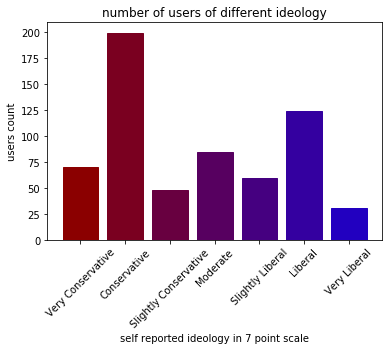

In [157]:
Ys = userprofile.counts.values
bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('users count')
plt.xticks(rotation = 45)
plt.title('number of users of different ideology')

Text(0.5, 1.0, 'average number of posts by users of different ideology')

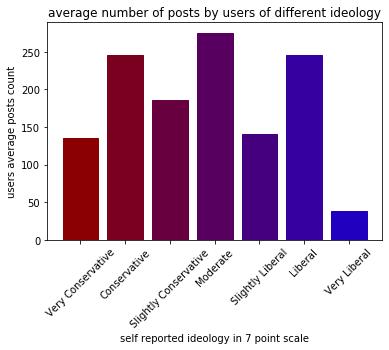

In [158]:
Ys = userprofile.ave_post.values
bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('users average posts count')
plt.xticks(rotation = 45)
plt.title('average number of posts by users of different ideology')

Text(0.5, 1.0, 'total number of posts from different ideology')

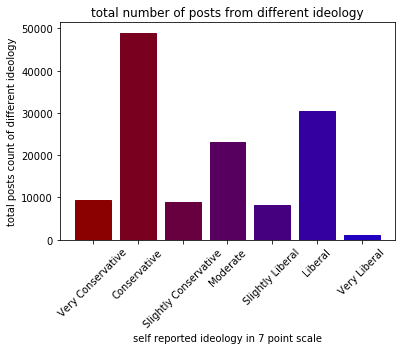

In [160]:
Ys = userprofile.total_post.values
bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('total posts count of different ideology')
plt.xticks(rotation = 45)
plt.title('total number of posts from different ideology')

In [169]:
userprofile_nomoder = userprofile.drop('Moderate', axis = 0)

In [170]:
userprofile_nomoder

,counts,ave_post,total_post,slantscale
political_leaning,,,,
Very Conservative,70,134.900000,9443,1
Conservative,199,246.110553,48976,2
Slightly Conservative,48,185.833333,8920,3
Slightly Liberal,59,140.101695,8266,5
Liberal,124,245.580645,30452,6
Very Liberal,31,38.451613,1192,7


In [173]:
fig = plt.figure(figsize = (10, 5))
xlabels = userprofile_nomoder.index.values


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'number of users of different ideology')

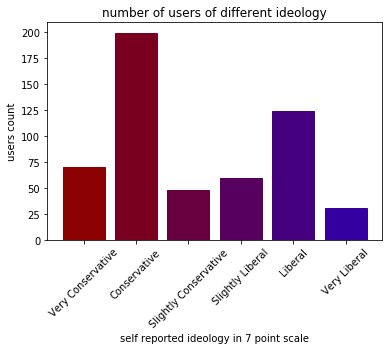

In [174]:
Ys = userprofile_nomoder.counts.values

bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('users count')
plt.xticks(rotation = 45)
plt.title('number of users of different ideology')

Text(0.5, 1.0, 'average number of posts by users of different ideology')

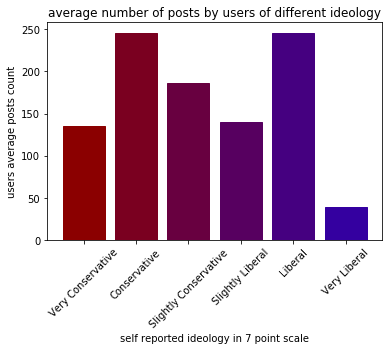

In [175]:
Ys = userprofile_nomoder.ave_post.values
bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('users average posts count')
plt.xticks(rotation = 45)
plt.title('average number of posts by users of different ideology')

Text(0.5, 1.0, 'total number of posts from different ideology')

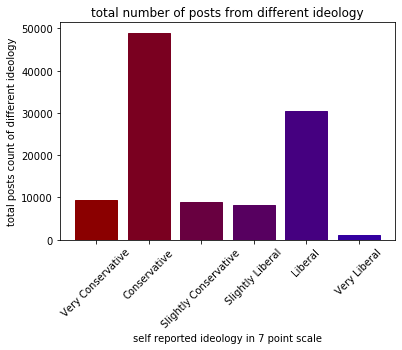

In [176]:
Ys = userprofile_nomoder.total_post.values
bars = plt.bar(xlabels, Ys)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["darkred","b"])
cnorm = mcol.Normalize(vmin=0,vmax=8)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
# colors = ['darkred', 'r', 'lightsalmon', 'green','lightblue', 'b', 'navy']
for i, bar in enumerate(bars):
    bar.set_color(cpick.to_rgba(i))
plt.xlabel('self reported ideology in 7 point scale')
plt.ylabel('total posts count of different ideology')
plt.xticks(rotation = 45)
plt.title('total number of posts from different ideology')

In [52]:
speeches_filt_2.columns

Index(['title', 'text_raw', 'subject_posttime', 'author', 'authorlink',
       'topics_prior', 'posturl', 'reply_posttime', 'upvoted', 'topics_name',
       'speech_final', '<fullpath>', 'name', 'massages', 'score', 'points',
       'awards', 'birthday', 'location', 'gender', 'occupation',
       'political_leaning', 'signature', 'slant_lib'],
      dtype='object')

In [17]:
# speeches_filt_2.loc[speeches_filt_2.loc[:, 'slant_lib'] == 4,['speech_final', 'political_leaning', 'slant_lib','author', 'topics_name']].to_csv(r'D:\projects\congress\data\debate_politics\filtered_data\debatepol_4topics_author_centermorderate.csv', 
#                                                                                                      sep = '\t', index_label = False)

NameError: name 'speeches_filt_2' is not defined

In [8]:
speeches_filt_2 = pd.read_csv(r'D:\projects\congress\data\debate_politics\filtered_data\debatepol_4topics_author_train.csv', 
                                                                                                     sep = '\t', index_col = 0)

In [9]:
speeches_filt_2.groupby('topics_name').size()

topics_name
abortion      35422
guns          71472
healthcare     6428
lgbtq         33126
dtype: int64

In [10]:
speeches_filt_2.shape

(146448, 24)

In [11]:
## test sampling scheme
'''
first of all, filter out moderate and centrist, as their political label is not clear. and a lot of self-claimed moderate are
actually not what they claim to be. 
next filter out topics that are not guns 26

'''

'\nfirst of all, filter out moderate and centrist, as their political label is not clear. and a lot of self-claimed moderate are\nactually not what they claim to be. \nnext filter out topics that are not guns 26\n\n'

In [12]:
sentence_vec = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/'+ r'debatepol_sentencevector.npy')

print(sentence_vec.shape, speeches_filt_2.loc[speeches_filt_2.topics_name == 'guns'].shape)

author_dummies = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'author_dummies.npy')
print(author_dummies.shape)

stance_7 = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_7scale.npy')
print(stance_7.shape)

stance_binary = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_binary.npy')

topics_hard = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_hard.npy')

topics_soft = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_soft.npy')

print(topics_soft.shape, topics_hard.shape)

speech_ids = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'speech_ids.npy')

(146448, 300) (71472, 24)
(146448, 1674)
(146448,)
(146448, 68) (146448, 68)


In [13]:
# start filter
# device a filter
_filter = (speeches_filt_2.slant_lib != 4)&(speeches_filt_2.topics_prior == 26)

stance_7g = stance_7[_filter]
author_dummiesg = author_dummies[_filter]

topics_softg = topics_soft[_filter]

topics_hardg = topics_hard[_filter]

print(topics_hardg.shape, stance_7g.shape)

stance_binaryg = (stance_7g>4)*1

print(stance_binaryg.mean(),(stance_7g==1).sum())

speech_idsg = speech_ids[_filter]
sentence_vecg = sentence_vec[_filter]

(52675, 68) (52675,)
0.4510299003322259 2201


In [16]:
(np.matmul(author_dummiesg.T, stance_binaryg)[author_dummiesg.T.sum(axis = 1)>0]>0).mean()
 # 61.3% cons in members who talks about guns

0.3872832369942196

In [19]:
1- stance_binaryg.mean()  # 54.9% cons in members who talks about guns

0.5489700996677741

In [83]:
topics_hardg.sum(axis = 0)

array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., 52675.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.])

In [202]:
# speeches_filt_2.loc[_filter& ((speeches_filt_2['slant_lib'] ==1)|(speeches_filt_2['slant_lib'] ==7)), ['author', 'political_leaning', 'slant_lib', 'topics_name',
#                                                                                                        'speech_final']].to_csv(r'D:\projects\congress\data\debate_politics\filtered_data\debatepol_guns_author_extreme.csv', 
#                                                                                                      sep = '\t', index_label = False)

In [ ]:
# save

In [217]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'author_dummies_guns_nomoder', author_dummiesg)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' +'sentence_vectors_guns_nomoder', sentence_vecg)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'speech_ids_guns_nomoder.npy', speech_idsg)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_7scale_guns_nomoder', stance_7g)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_binary_guns_nomoder', stance_binaryg)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_hard_guns_nomoder', topics_hardg)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_soft_guns_nomoder', topics_softg)

In [89]:
stance_binaryg.shape

(52675,)

In [84]:
ids_all = np.load(r'D:\projects\congress\processed\training_vectors\debatepol/' 'speech_ids.npy', allow_pickle= True)

In [85]:
ids_all.shape

(146448,)

In [78]:
# # start a new filter, include 
# device a filter
_filter2 = (speeches_filt_2.topics_prior == 26)

stance_7m = stance_7[_filter2]
author_dummiesm = author_dummies[_filter2]

topics_softm = topics_soft[_filter2]

topics_hardm = topics_hard_[_filter2]

print(topics_hardm.shape, stance_7m.shape)

stance_binarym = (stance_7m>4)*1 # moderate as 0

print(stance_binarym.mean(),(stance_7m==1).sum())

speech_idsm = speech_ids[_filter2]
sentence_vecm = sentence_vec[_filter2]

(71472, 68) (71472,)
0.33240989478397137 2201


In [80]:
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'author_dummies_guns_wmoder', author_dummiesm)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' +'sentence_vectors_guns_wmoder', sentence_vecm)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'speech_ids_guns_wmoder.npy', speech_idsm)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_7scale_guns_wmoder', stance_7m)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'stance_lib_binary_guns_wmoder', stance_binarym)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_hard_guns_wmoder', topics_hardm)
np.save(r'D:\projects\congress\processed\training_vectors\debatepol/' + 'topics_soft_guns_wmoder', topics_softm)

In [82]:
topics_hardm.sum(axis = 0)

array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., 71472.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.])

In [2]:
### test sampling scheme

datapath = r'D:\projects\congress\processed\training_vectors\debatepol/' 
ds_all = np.load(os.path.join(datapath, 'sentence_vectors_guns_nomoder.npy'))



thetas_soft_all = np.load(os.path.join(datapath, 'topics_soft_guns_nomoder.npy'))

thetas_hard_all = np.load(os.path.join(datapath, 'topics_soft_guns_nomoder.npy'))

theta_categ= np.argmax(thetas_hard_all, axis = -1)


# ds_all = np.load(os.path.join(datapath, 'cong_reports_102_114_for_training_sif.npz'))['arr_0'][bottom:]

# oversample = SMOTE()

parties_all = np.load(os.path.join(datapath, 'stance_lib_binary_guns_nomoder.npy'))
stance_all = np.load(os.path.join(datapath, 'stance_lib_7scale_guns_nomoder.npy'))
y = parties_all.copy()




print(parties_all.mean())
totals = len(ds_all)

###########change 50 to lantent dim if latent dim is modified
Zmus_pre = np.zeros([len(ds_all), 50])
ds_all = np.float32(ds_all)
thetas_all = thetas_hard_all


# print(ds.shape)
As_all = np.load(os.path.join(datapath, 'author_dummies_guns_nomoder.npy')) # change it to true authors when applicable


# print("Author matrix shape is ", As_all.shape)

T00 = np.load(os.path.join(datapath, 'debatepol_Topicvectors_withother.npy'))

ids_all = np.load(os.path.join(datapath, 'speech_ids.npy'), allow_pickle= True)
# P0 = np.load(os.path.join(FLAGS.data_dir, 'PR_axis_piror_1991_{}.npy'.format(enddate)))
# P0 = np.roll(P0, -1, axis = 0) # orignal P0 first row corresponding to the null topic, which is the last topic,
# P0 = np.load(r'C:\code\chen_proj_codes\\news_bias\congressionalreport\processed\congress_report_topics\trial_data\PR_sample_piror.npy')
# assert P0.shape ==(68, 300), 'dr axis prior shape error'
# thetas_all = thetas0_all.copy()
T0 = T00.copy()
# print('loaded data')
# split

Zbar0 = np.matmul(As_all.T, Zmus_pre)/(np.sum(As_all, axis = 0)[:, np.newaxis]+0.000001)

0.4510299003322259


In [3]:
Zbar0.shape


(1674, 50)

In [32]:
# calculate Zbar0 matrix
biased = True
notmask = 0.8
mask_ = np.array([0]* len(parties_all))
if not biased:
    sss = StratifiedShuffleSplit(n_splits=5, test_size= 1- FLAGS.notmask)
    train_id, test_id = next(sss.split(theta_categ, parties_all))
    mask_[train_id] = 1
    # print("non zero results", sum(mask_))
    
    mask_pre = mask_.copy()
else:
    orderid = np.argsort(stance_all)
    tbn = int(len(parties_all) * notmask/2)
    train_id = np.concatenate([orderid[:tbn], orderid[-tbn:]])
    test_id = [i for i in range(len(orderid)) if i not in train_id]
    mask_[train_id] = 1
    mask_pre = mask_.copy()

In [33]:
totalsamp = len(parties_all)
mask_ = np.array([0]* totalsamp)
if not biased:
    sss = StratifiedShuffleSplit(n_splits=5, test_size= 1- FLAGS.notmask)
    train_id, test_id = next(sss.split(theta_categ, parties_all))
    mask_[train_id] = 1
    # print("non zero results", sum(mask_))
    mask_pre = mask_.copy()
else:
    p = np.array([(4- i)**4  if i <4 else (i -4)**4 for i in stance_all])
    p = p / np.sum(p)

    train_id = np.random.choice(np.arange(totalsamp), int(totalsamp * notmask), replace = False, p = p)

    test_id = [i for i in range(totalsamp) if i not in train_id]
    mask_[train_id] = 1
    mask_pre = mask_.copy()


In [34]:
p = np.array([(4- i)**3  if i <4 else (i -4)**3 for i in stance_all])
p

array([8, 8, 8, ..., 8, 8, 8], dtype=int64)

In [35]:
len(train_id)

42140

In [36]:
totalsamp

52675

In [37]:
train_id

array([18402, 51268, 51475, ..., 44358, 19056, 37388])

In [39]:
(np.abs(stance_all[train_id]-4)>2).sum()/42140

0.06862838158519222

In [20]:
(p == 27).sum()

2892

In [21]:
226/5267

0.0429086766660338

In [22]:
2892/52675

0.05490270526815377